<img src = 'Data/poule.png' />

<h1><center><font color='red'> Etude de marché pour un développement à l'international </font></center></h1>

* [Importation des librairies et création de fonctions](#chapter1)
* [Importation et nettoyage du fichier Population](#chapter2)
* [Importation et nettoyage du fichier Disponibilité](#chapter3)
    * [Différence entre les 2 fichiers](#section3_1)
    * [Création du dataframe Viande de Volailles](#section3_2)
* [Importation de fichiers supplémentaires](#chapter4)
    * [Données Import/Export](#section4_1)
    * [Données Frais de douanes](#section4_2)
    * [Données de la sécurité alimentaire](#section4_3)
* [Jointure des données](#chapter5)

# Importation des librairies et création de fonctions<a class="anchor" id="chapter1"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
def infosurdf(df):
    df_info = pd.DataFrame(df.dtypes).T.rename(index={0:"type de la colonne"})
    df_info = df_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:"nombre de valeurs NaN"}))
    df_info = df_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100).T.rename(index={0:"valeurs nulles en %"}))
    df_info = df_info.append(pd.DataFrame(df.nunique()).T.rename(index={0:"nombre de valeurs uniques"}))
    df_info = df_info.append(pd.DataFrame(df.count()).T.rename(index={0:"nombre de valeurs totales"}))
    return df_info

def matrice_corr(df):
    plt.figure(figsize=(15,15))
    mask = np.triu(np.ones_like(df.corr(), dtype=bool))
    sns.heatmap(df.corr(), mask=mask, center=0, cmap='RdBu', 
                linewidths=1, annot=True, fmt=".2f", vmin=-1, vmax=1)
    plt.title('Carte des corrélations', fontsize = 15, fontweight='bold')
    plt.show()

# Fichier Population<a class="anchor" id="chapter2"></a>
idem fichier Population.csv du P8

2000-2005 : 229 pays<br>2006-2010 : 230 pays (séparation de la Serbie-Monténégro)<br>2011 : 235 pays<br>2012-2018 :236 pays (Séparation du Soudan)

Anciennes Antilles Neerlandaises<br>Bonaire st eustache, ... : Nan de 2000 à 2010 inclus<br>Curaçao : idem<br>Sint Marteen : idem

anciennes communes de la Guadeloupe<br>St Barth : idem<br>St Martin : idem

Monténégro : Nan de 2000 à 2005 (218000 en 2006)<br>Serbie : idem<br>Serbie et Monténégro : Nan de 2006 à 2018

Soudan : Nan de 2000 à 2011<br>Soudan du Sud : idem<br>Soudan (ex) : Nan de 2012 à 2018

L'étude se fera sur les années 2017-2020, 2 pays ont donné place à 2 nouvelles entités, ces anciennes entités seront supprimées.

In [3]:
pop_df = pd.read_csv('Data/Population_2000_2018.csv')
infosurdf(pop_df)

,Code Domaine,Domaine,Code zone,Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole,Note
type de la colonne,object,object,int64,object,int64,object,int64,object,int64,int64,object,float64,object,object,object
nombre de valeurs NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4153
valeurs nulles en %,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,94.150986
nombre de valeurs uniques,1,1,238,238,1,1,1,1,19,19,1,4398,2,2,1
nombre de valeurs totales,4411,4411,4411,4411,4411,4411,4411,4411,4411,4411,4411,4411,4411,4411,258


Les colonnes avec une valeur unique seront écartées, tout comme celles concernant les codes FAO

In [4]:
# sélection des colonnes
pop_df = pop_df[['Zone','Année', 'Valeur']]
pop_df = pop_df.rename(columns={'Valeur':'Population'})
pop_df.Population = pop_df.Population * 1000

# pivot
pop_df = pd.pivot_table(pop_df, values='Population',index='Zone', columns='Année')
pop_df['Croissance démographique (en %)'] = round((pop_df[2017] - pop_df[2016]) * 100 / pop_df[2016],2)
pop_df = pop_df[[2017,'Croissance démographique (en %)']].rename(columns={2017:'Population'})
pop_df['Année']=2017

# suppression des pays n'existant plus
pop_df = pop_df.drop({'Serbie-et-Monténégro','Soudan (ex)'})

Nous verrons que ces 236 pays n'ont pas tous une correspondance avec les autres fichiers.

## Ajout du code ISO

In [5]:
iso = pd.read_csv('Data/ISO_pays_fr.csv')
pop_df = pop_df.merge(iso, on='Zone', how='left')
infosurdf(pop_df)

,Zone,Population,Croissance démographique (en %),Année,id
type de la colonne,object,float64,float64,int64,object
nombre de valeurs NaN,0,0,0,0,23
valeurs nulles en %,0.0,0.0,0.0,0.0,9.745763
nombre de valeurs uniques,236,236,177,1,213
nombre de valeurs totales,236,236,236,236,213


# Fichier Disponibilité<a class="anchor" id="chapter3"></a>

In [6]:
disp_df = pd.read_csv('Data/DisponibiliteAlimentaire_2017.csv')
infosurdf(disp_df)

,Code Domaine,Domaine,Code zone,Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole
type de la colonne,object,object,int64,object,int64,object,int64,object,int64,int64,object,float64,object,object
nombre de valeurs NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0
valeurs nulles en %,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
nombre de valeurs uniques,1,1,174,174,17,17,98,98,1,1,4,7250,2,2
nombre de valeurs totales,176600,176600,176600,176600,176600,176600,176600,176600,176600,176600,176600,176600,176600,176600


Dispo int = prod + import - variation de stocks - export

et aussi

Dispo int = Nourriture + traitement + résidus

Tout comme pour le fichier Population, les colonnes avec une seule valeur ou qui concernent les codes FAO seront écartées.

In [7]:
disp_df = disp_df[['Zone', 'Élément', 'Produit', 'Unité', 'Valeur']]
disp_df

,Zone,Élément,Produit,Unité,Valeur
0,Afghanistan,Production,Blé et produits,Milliers de tonnes,4281.00
1,Afghanistan,Importations - Quantité,Blé et produits,Milliers de tonnes,2302.00
2,Afghanistan,Variation de stock,Blé et produits,Milliers de tonnes,-119.00
3,Afghanistan,Exportations - Quantité,Blé et produits,Milliers de tonnes,0.00
4,Afghanistan,Disponibilité intérieure,Blé et produits,Milliers de tonnes,6701.00
...,...,...,...,...,...
176595,Zimbabwe,Nourriture,Miscellanees,Milliers de tonnes,19.00
176596,Zimbabwe,Disponibilité alimentaire en quantité (kg/pers...,Miscellanees,kg,1.33
176597,Zimbabwe,Disponibilité alimentaire (Kcal/personne/jour),Miscellanees,Kcal/personne/jour,1.00
176598,Zimbabwe,Disponibilité de protéines en quantité (g/pers...,Miscellanees,g/personne/jour,0.04


# Différence entre les 2 df<a class="anchor" id="section3_1"></a>
Le nombre d'occurences des pays est différent entre les 2 fichiers, nous pouvons établir la liste des pays ne se trouvant pas dans le second fichier

In [8]:
# liste des pays dans chaque fichier

list_1 = disp_df.Zone.unique()
list_2 = pop_df.Zone.unique()

# différence entre les 2 listes

difference_1 = set(list_1).difference(set(list_2))
difference_2 = set(list_2).difference(set(list_1))

list_difference = list(difference_1.union(difference_2))
print(list_difference)

['Soudan du Sud', 'Burundi', 'Îles Marshall', 'Samoa américaines', 'Guinée équatoriale', 'Îles Vierges britanniques', 'Érythrée', 'Andorre', 'République démocratique du Congo', 'Qatar', 'Nauru', 'Somalie', 'Gibraltar', 'Monaco', 'Anguilla', 'Curaçao', 'Tokélaou', 'Bonaire, Saint-Eustache et Saba', 'Seychelles', 'Îles Wallis-et-Futuna', 'Tuvalu', 'Îles Vierges américaines', 'Guam', 'Sint Maarten  (partie néerlandaise)', 'Martinique', 'Antilles néerlandaises (ex)', 'Montserrat', 'Îles Féroé', 'Bhoutan', 'Bahreïn', 'Tonga', 'Îles Turques-et-Caïques', 'Micronésie (États fédérés de)', 'Saint-Siège', 'Îles Cook', 'Porto Rico', 'Liechtenstein', 'Libye', 'Mayotte', 'République arabe syrienne', 'Îles Caïmanes', 'Îles Falkland (Malvinas)', 'Palaos', 'Singapour', 'Îles Anglo-Normandes', 'Île de Man', 'Comores', 'Aruba', 'Nioué', 'Papouasie-Nouvelle-Guinée', 'Guadeloupe', 'Guyane française', 'Saint-Marin', 'Sahara occidental', 'Saint-Martin (partie française)', 'Réunion', 'Saint-Barthélemy', 'Pale

Les pays de cette liste sont des pays de petite taille ou des pays en conflit

# Création d'un dataframe Volailles<a class="anchor" id="section3_2"></a>
Nous commençons notre étude en sélectionnant les données "Viande de Volailles"

In [9]:
volaille = disp_df[disp_df['Produit'] == 'Viande de Volailles']
volaille.head()

,Zone,Élément,Produit,Unité,Valeur
651,Afghanistan,Production,Viande de Volailles,Milliers de tonnes,28.0
652,Afghanistan,Importations - Quantité,Viande de Volailles,Milliers de tonnes,29.0
653,Afghanistan,Variation de stock,Viande de Volailles,Milliers de tonnes,0.0
654,Afghanistan,Disponibilité intérieure,Viande de Volailles,Milliers de tonnes,57.0
655,Afghanistan,Pertes,Viande de Volailles,Milliers de tonnes,2.0


Nous passons les différentes variables de la colonne Element en colonnes et les pays en lignes

In [10]:
volaille = pd.pivot_table(volaille, values='Valeur', index='Zone', columns='Élément') # fill_value=0 pour remplacer les Nan
infosurdf(volaille)

Élément,Alimentation pour touristes,Aliments pour animaux,Autres utilisations (non alimentaire),Disponibilité alimentaire (Kcal/personne/jour),Disponibilité alimentaire en quantité (kg/personne/an),Disponibilité de matière grasse en quantité (g/personne/jour),Disponibilité de protéines en quantité (g/personne/jour),Disponibilité intérieure,Exportations - Quantité,Importations - Quantité,Nourriture,Pertes,Production,Résidus,Semences,Traitement,Variation de stock
type de la colonne,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
nombre de valeurs NaN,94,171,138,0,0,0,0,2,37,2,2,105,4,8,171,126,3
valeurs nulles en %,54.651163,99.418605,80.232558,0.0,0.0,0.0,0.0,1.162791,21.511628,1.162791,1.162791,61.046512,2.325581,4.651163,99.418605,73.255814,1.744186
nombre de valeurs uniques,7,1,18,112,169,156,164,135,50,84,130,32,125,15,1,25,55
nombre de valeurs totales,78,1,34,172,172,172,172,170,135,170,170,67,168,164,1,46,169


Quelles colonnes garder sur les 17 ainsi créées?

In [11]:
volaille = volaille[['Disponibilité de protéines en quantité (g/personne/jour)', 'Disponibilité intérieure', 
                     'Exportations - Quantité', 'Importations - Quantité', 'Nourriture', 'Production', 'Variation de stock']]

# ajout du code ISO3
volaille = pd.merge(volaille, iso, on='Zone', how='left')
infosurdf(volaille)

,Zone,Disponibilité de protéines en quantité (g/personne/jour),Disponibilité intérieure,Exportations - Quantité,Importations - Quantité,Nourriture,Production,Variation de stock,id
type de la colonne,object,float64,float64,float64,float64,float64,float64,float64,object
nombre de valeurs NaN,0,0,2,37,2,2,4,3,0
valeurs nulles en %,0.0,0.0,1.162791,21.511628,1.162791,1.162791,2.325581,1.744186,0.0
nombre de valeurs uniques,172,164,135,50,84,130,125,55,172
nombre de valeurs totales,172,172,170,135,170,170,168,169,172


Nous avons 21% de valeurs nulles dans la colonne Exportations, nous pouvons remplacer ses valeurs en utilisant l'égalité suivante :<br><center>Dispo int = Production + Import - Variation de stock - Export</center><center>Export = Production + Import - Dispo int - Variation de stock</center>

In [12]:
volaille_null = volaille[volaille.isnull().any(axis=1)]
volaille_null['Exportations - Quantité'] = volaille_null['Production'] + volaille_null['Importations - Quantité'] - volaille_null['Disponibilité intérieure'] - volaille_null['Variation de stock']
volaille_null

,Zone,Disponibilité de protéines en quantité (g/personne/jour),Disponibilité intérieure,Exportations - Quantité,Importations - Quantité,Nourriture,Production,Variation de stock,id
0,Afghanistan,0.54,57.0,0.0,29.0,55.0,28.0,0.0,AFG
13,Bahamas,14.61,26.0,0.0,24.0,16.0,6.0,4.0,BHS
14,Bangladesh,0.47,250.0,-1.0,0.0,240.0,249.0,0.0,BGD
23,Burkina Faso,0.77,46.0,0.0,0.0,44.0,46.0,0.0,BFA
26,Cabo Verde,6.52,10.0,-1.0,12.0,9.0,1.0,4.0,CPV
27,Cambodge,0.74,38.0,0.0,10.0,37.0,28.0,0.0,KHM
40,Cuba,7.12,342.0,0.0,312.0,269.0,29.0,-1.0,CUB
43,Djibouti,0.92,3.0,NaN,3.0,3.0,NaN,0.0,DJI
54,Gambie,1.24,8.0,0.0,16.0,8.0,2.0,10.0,GAM
56,Grenade,15.50,8.0,0.0,7.0,5.0,1.0,0.0,GRD


Les approximations font apparaître des nombres négatifs pour certaines valeurs d'Export. Nous les remplaçons par 0

In [13]:
volaille_null.loc[volaille_null['Exportations - Quantité']<0, 'Exportations - Quantité']=0

Nous remplaçons ses valeurs dans le DF initial

In [14]:
volaille = volaille.dropna()
volaille = volaille.append(volaille_null)
volaille

,Zone,Disponibilité de protéines en quantité (g/personne/jour),Disponibilité intérieure,Exportations - Quantité,Importations - Quantité,Nourriture,Production,Variation de stock,id
1,Afrique du Sud,14.11,2118.0,63.0,514.0,2035.0,1667.0,0.0,ZAF
2,Albanie,6.26,47.0,0.0,38.0,47.0,13.0,4.0,ALB
3,Algérie,1.97,277.0,0.0,2.0,264.0,275.0,0.0,DZA
4,Allemagne,7.96,1739.0,646.0,842.0,1609.0,1514.0,-29.0,DEU
5,Angola,3.60,319.0,0.0,277.0,315.0,42.0,0.0,AGO
...,...,...,...,...,...,...,...,...,...
152,Timor-Leste,1.46,5.0,0.0,11.0,5.0,1.0,7.0,TLS
156,Turkménistan,1.53,27.0,0.0,9.0,26.0,20.0,2.0,TKM
160,Vanuatu,4.05,3.0,1.0,4.0,3.0,1.0,1.0,VUT
165,Zimbabwe,1.59,76.0,0.0,6.0,67.0,69.0,0.0,ZWE


In [15]:
infosurdf(volaille)

,Zone,Disponibilité de protéines en quantité (g/personne/jour),Disponibilité intérieure,Exportations - Quantité,Importations - Quantité,Nourriture,Production,Variation de stock,id
type de la colonne,object,float64,float64,float64,float64,float64,float64,float64,object
nombre de valeurs NaN,0,0,2,5,2,2,4,3,0
valeurs nulles en %,0.0,0.0,1.162791,2.906977,1.162791,1.162791,2.325581,1.744186,0.0
nombre de valeurs uniques,172,164,135,50,84,130,125,55,172
nombre de valeurs totales,172,172,170,167,170,170,168,169,172


# Autres données<a class="anchor" id="chapter4"></a>
## Données Import/Export<a class="anchor" id="section4_1"></a>
Nous avons récupéré sur le site de la FAO les données concernant l'import et l'export de viande de volailles dans le monde. Le code ISO3 a directement été ajouté lors de la sélection des données.

In [16]:
trade = pd.read_csv('Data/trade_meat_chicken.csv')
trade

,id,Zone,Element,Unit,Value
0,AFG,Afghanistan,Import Quantity,tonnes,28937.0
1,AFG,Afghanistan,Import Value,1000 US$,28934.0
2,AFG,Afghanistan,Export Quantity,tonnes,37.0
3,AFG,Afghanistan,Export Value,1000 US$,31.0
4,ALB,Albania,Import Quantity,tonnes,17515.0
...,...,...,...,...,...
661,ZMB,Zambia,Import Value,1000 US$,7500.0
662,ZMB,Zambia,Export Quantity,tonnes,958.0
663,ZMB,Zambia,Export Value,1000 US$,1503.0
664,ZWE,Zimbabwe,Import Quantity,tonnes,5877.0


Le prix de la viande de volailles n'est pas le même selon le pays (1 dollar US le kg pour l'Afghanistan, 4.5 dollar US pour l'Australie)

Comme précédemment, on procède à un pivot des données.

In [17]:
trade = pd.pivot_table(trade, values='Value', index=['id','Zone'], columns='Element').drop(columns={'Export Quantity'})
# création d'une colonne prix au kg (equivalente au k$/t)
trade['Import Value ($/kg)'] = round(trade['Import Value'] / trade['Import Quantity'],2)
trade = trade['Import Value ($/kg)']
trade

id   Zone                
AFG  Afghanistan             1.00
AGO  Angola                  1.12
ALB  Albania                 0.94
ARE  United Arab Emirates    1.64
ARG  Argentina               1.86
                             ... 
WSM  Samoa                   1.18
YEM  Yemen                   1.60
ZAF  South Africa            0.85
ZMB  Zambia                  0.62
ZWE  Zimbabwe                0.78
Name: Import Value ($/kg), Length: 194, dtype: float64

Nous avons beaucoup de valeurs manquantes pour les valeurs à l'export, nous ne gardons que la valeur à l'import

## Données des taux des droits de douane<a class="anchor" id="section4_2"></a>
Ce fichier provient des ressources en ligne de la banque mondiale. Il contient les taux connus des différents pays. Les valeurs les plus récentes ont été retenues et agrégées dans la même colonne.<br>Autre source utilisée : https://fr.wikipedia.org/wiki/Liste_des_pays_class%C3%A9s_selon_leurs_tarifs_douaniers

In [18]:
douane = pd.read_csv('Data/douanes.csv')
douane

,Zone,id,Taux des droits de douane
0,Aruba,ABW,12.12
1,Afghanistan,AFG,5.63
2,Angola,AGO,9.23
3,Albanie,ALB,1.10
4,Andorre,AND,NaN
...,...,...,...
214,Kosovo,XKX,NaN
215,"Yémen, Rép. du",YEM,5.03
216,Afrique du Sud,ZAF,4.40
217,Zambie,ZMB,4.82


## Données de sécurité alimentaire<a class="anchor" id="section4_3"></a>
Nous avons aussi récupéré les indicateurs de l'apport en protéines animales (par habitant et par jour), du PIB par habitant et de l'indice de stabilité politique.

In [19]:
secu = pd.read_csv('Data/food_security.csv')
secu

,id,Zone,Element,Value
0,AFG,Afghanistan,Average supply of protein of animal origin (g/...,10.70
1,AFG,Afghanistan,Gross domestic product ($/cap),2058.40
2,AFG,Afghanistan,Political stability and absence of violence/te...,-2.80
3,ALB,Albania,Average supply of protein of animal origin (g/...,62.70
4,ALB,Albania,Gross domestic product ($/cap),12771.00
...,...,...,...,...
552,ZMB,Zambia,Gross domestic product ($/cap),3485.00
553,ZMB,Zambia,Political stability and absence of violence/te...,0.15
554,ZWE,Zimbabwe,Average supply of protein of animal origin (g/...,11.00
555,ZWE,Zimbabwe,Gross domestic product ($/cap),3274.60


In [20]:
secu = pd.pivot_table(secu, values='Value', index=['id','Zone'], columns='Element')
infosurdf(secu)

Element,Average supply of protein of animal origin (g/cap/day),Gross domestic product ($/cap),Political stability and absence of violence/terrorism (index)
type de la colonne,float64,float64,float64
nombre de valeurs NaN,28,14,4
valeurs nulles en %,13.930348,6.965174,1.99005
nombre de valeurs uniques,122,187,151
nombre de valeurs totales,173,187,197


# Jointure des différents dataframes<a class="anchor" id="chapter5"></a>
La jointure se fait grâce au code ISO3

In [21]:
df = pd.merge(trade, secu, on='id', how='inner')
df = pd.merge(df, douane, on='id', how='inner').drop(columns={'Zone'})
df = pd.merge(df, pop_df, on='id', how='inner').drop(columns={'Année','Zone'})
df

,id,Import Value ($/kg),Average supply of protein of animal origin (g/cap/day),Gross domestic product ($/cap),Political stability and absence of violence/terrorism (index),Taux des droits de douane,Population,Croissance démographique (en %)
0,AFG,1.00,10.7,2058.4,-2.80,5.63,36296113.0,2.58
1,AGO,1.12,15.7,7310.9,-0.33,9.23,29816766.0,3.38
2,ALB,0.94,62.7,12771.0,0.38,1.10,2884169.0,-0.08
3,ARE,1.64,50.7,67183.6,0.62,3.28,9487203.0,1.35
4,ARG,1.86,67.3,23597.1,0.17,6.88,43937140.0,0.99
...,...,...,...,...,...,...,...,...
181,WSM,1.18,52.7,6480.8,1.18,10.38,195352.0,0.42
182,YEM,1.60,9.0,NaN,-2.94,5.03,27834819.0,2.45
183,ZAF,0.85,36.0,12701.3,-0.28,4.40,57009756.0,1.43
184,ZMB,0.62,12.0,3485.0,0.15,4.82,16853599.0,3.00


Nous ajoutons finalement notre df sur la viande de volailles puis enlevons la colonne id qui ne nous servira plus

In [22]:
df = pd.merge(df, volaille, on='id', how='inner').drop(columns='id')
df

,Import Value ($/kg),Average supply of protein of animal origin (g/cap/day),Gross domestic product ($/cap),Political stability and absence of violence/terrorism (index),Taux des droits de douane,Population,Croissance démographique (en %),Zone,Disponibilité de protéines en quantité (g/personne/jour),Disponibilité intérieure,Exportations - Quantité,Importations - Quantité,Nourriture,Production,Variation de stock
0,1.00,10.7,2058.4,-2.80,5.63,36296113.0,2.58,Afghanistan,0.54,57.0,0.0,29.0,55.0,28.0,0.0
1,1.12,15.7,7310.9,-0.33,9.23,29816766.0,3.38,Angola,3.60,319.0,0.0,277.0,315.0,42.0,0.0
2,0.94,62.7,12771.0,0.38,1.10,2884169.0,-0.08,Albanie,6.26,47.0,0.0,38.0,47.0,13.0,4.0
3,1.64,50.7,67183.6,0.62,3.28,9487203.0,1.35,Émirats arabes unis,14.80,412.0,94.0,433.0,412.0,48.0,-26.0
4,1.86,67.3,23597.1,0.17,6.88,43937140.0,0.99,Argentine,13.53,1962.0,207.0,8.0,1856.0,2161.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,1.18,52.7,6480.8,1.18,10.38,195352.0,0.42,Samoa,21.88,15.0,0.0,17.0,13.0,0.0,2.0
163,1.60,9.0,NaN,-2.94,5.03,27834819.0,2.45,Yémen,3.04,246.0,0.0,78.0,237.0,168.0,0.0
164,0.85,36.0,12701.3,-0.28,4.40,57009756.0,1.43,Afrique du Sud,14.11,2118.0,63.0,514.0,2035.0,1667.0,0.0
165,0.62,12.0,3485.0,0.15,4.82,16853599.0,3.00,Zambie,1.15,60.0,1.0,12.0,58.0,49.0,0.0


Nous définissons la colonne Pays comme index, notre df ne contiendra que des valeurs numériques

In [23]:
df = df.set_index('Zone')

df = df[['Gross domestic product ($/cap)', 'Political stability and absence of violence/terrorism (index)',
         'Taux des droits de douane', 'Population','Croissance démographique (en %)',
         'Disponibilité de protéines en quantité (g/personne/jour)', 'Average supply of protein of animal origin (g/cap/day)',
         'Disponibilité intérieure', 'Exportations - Quantité',  'Importations - Quantité', 
         'Import Value ($/kg)', 'Nourriture', 'Production', 'Variation de stock']]
df = df.rename(columns={'Gross domestic product ($/cap)':'PIB en $/hab', 'Political stability and absence of violence/terrorism (index)':'Index de stabilité',
                        'Disponibilité de protéines en quantité (g/personne/jour)':'Disponibilité en protéines de volailles (g/pers/jour)',
                        'Average supply of protein of animal origin (g/cap/day)':'Disponibilité en protéines animales (g/pers/jour)'})

In [24]:
infosurdf(df)

,PIB en $/hab,Index de stabilité,Taux des droits de douane,Population,Croissance démographique (en %),Disponibilité en protéines de volailles (g/pers/jour),Disponibilité en protéines animales (g/pers/jour),Disponibilité intérieure,Exportations - Quantité,Importations - Quantité,Import Value ($/kg),Nourriture,Production,Variation de stock
type de la colonne,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
nombre de valeurs NaN,6,3,4,0,0,0,0,2,5,2,5,2,4,3
valeurs nulles en %,3.592814,1.796407,2.39521,0.0,0.0,0.0,0.0,1.197605,2.994012,1.197605,2.994012,1.197605,2.39521,1.796407
nombre de valeurs uniques,161,131,130,167,134,160,118,132,50,83,119,127,122,54
nombre de valeurs totales,161,164,163,167,167,167,167,165,162,165,162,165,163,164


Regardons les valeurs manquantes restantes :

In [25]:
df_null = df[df.isnull().any(axis=1)]
df_null

,PIB en $/hab,Index de stabilité,Taux des droits de douane,Population,Croissance démographique (en %),Disponibilité en protéines de volailles (g/pers/jour),Disponibilité en protéines animales (g/pers/jour),Disponibilité intérieure,Exportations - Quantité,Importations - Quantité,Import Value ($/kg),Nourriture,Production,Variation de stock
Zone,,,,,,,,,,,,,,
"Chine, continentale",14621.2,NaN,2.47,1.421022e+09,0.49,3.96,40.3,18161.0,576.0,452.0,1.86,17518.0,18236.0,-50.0
Cuba,NaN,0.65,8.83,1.133925e+07,0.04,7.12,33.0,342.0,0.0,312.0,0.95,269.0,29.0,-1.0
Djibouti,4885.2,-0.74,17.56,9.440990e+05,1.61,0.92,14.0,3.0,NaN,3.0,1.74,3.0,NaN,0.0
Indonésie,10935.6,-0.50,2.04,2.646510e+08,1.18,2.42,20.7,2323.0,0.0,1.0,NaN,1904.0,2301.0,-21.0
Israël,38834.0,-0.89,1.85,8.243848e+06,1.66,27.87,73.3,636.0,3.0,0.0,NaN,556.0,629.0,-10.0
Kiribati,2235.7,0.88,NaN,1.141580e+05,1.45,6.65,36.7,2.0,0.0,1.0,2.01,2.0,1.0,0.0
République démocratique populaire lao,7257.8,0.40,0.97,6.953035e+06,1.57,3.59,18.0,NaN,NaN,NaN,1.73,NaN,NaN,NaN
Maldives,18058.6,0.23,11.55,4.964020e+05,4.39,4.70,52.8,12.0,NaN,12.0,1.89,7.0,NaN,0.0
Nouvelle-Calédonie,NaN,NaN,NaN,2.771500e+05,1.08,14.05,49.7,11.0,0.0,9.0,2.07,11.0,1.0,-1.0


La Chine est un potentiel client, nous ne pouvons pas l'exclure, nous devons donc entrer une valeur pour la stabilité politique (0).<br>Les pays dont les importations sont inférieures à 15t ou manquantes seront écartées de notre étude, ce sont des pays de petite taille ou avec des régulations spécifiques (viande Kasher en Israël)

In [26]:
df_null = df_null[df_null['Importations - Quantité'] > 15]
df_null

,PIB en $/hab,Index de stabilité,Taux des droits de douane,Population,Croissance démographique (en %),Disponibilité en protéines de volailles (g/pers/jour),Disponibilité en protéines animales (g/pers/jour),Disponibilité intérieure,Exportations - Quantité,Importations - Quantité,Import Value ($/kg),Nourriture,Production,Variation de stock
Zone,,,,,,,,,,,,,,
"Chine, continentale",14621.2,NaN,2.47,1.421022e+09,0.49,3.96,40.3,18161.0,576.0,452.0,1.86,17518.0,18236.0,-50.0
Cuba,NaN,0.65,8.83,1.133925e+07,0.04,7.12,33.0,342.0,0.0,312.0,0.95,269.0,29.0,-1.0
Pérou,12506.5,-0.26,0.66,3.144430e+07,1.68,6.71,29.0,1523.0,NaN,60.0,1.15,424.0,1465.0,NaN
Venezuela (République bolivarienne du),NaN,-1.25,14.06,2.940248e+07,-1.50,7.23,24.7,626.0,0.0,25.0,2.55,596.0,600.0,-1.0
Yémen,NaN,-2.94,5.03,2.783482e+07,2.45,3.04,9.0,246.0,0.0,78.0,1.60,237.0,168.0,0.0


Nous recherchons sur l'Internet, les quelques valeurs qui nous manquent

In [27]:
# modification de la valeur de stabilité politique pour la Chine
df_null.loc[df_null.index[0], 'Index de stabilité'] = 0

# modification de la valeur du PIB/habitant pour Cuba, le Venezuela et le Yémen
df_null.loc[df_null.index[1], 'PIB en $/hab'] = 21016.6
df_null.loc[df_null.index[3], 'PIB en $/hab'] = 17131.4
df_null.loc[df_null.index[4], 'PIB en $/hab'] = 2285.0

# modification de la valeur des exportations et de la variation de stocks pour le Pérou
df_null.loc[df_null.index[2], 'Variation de stock'] = 0
df_null.loc[df_null.index[2], 'Exportations - Quantité'] = 2

In [28]:
df = df.dropna()
df = df.append(df_null)
df

,PIB en $/hab,Index de stabilité,Taux des droits de douane,Population,Croissance démographique (en %),Disponibilité en protéines de volailles (g/pers/jour),Disponibilité en protéines animales (g/pers/jour),Disponibilité intérieure,Exportations - Quantité,Importations - Quantité,Import Value ($/kg),Nourriture,Production,Variation de stock
Zone,,,,,,,,,,,,,,
Afghanistan,2058.4,-2.80,5.63,3.629611e+07,2.58,0.54,10.7,57.0,0.0,29.0,1.00,55.0,28.0,0.0
Angola,7310.9,-0.33,9.23,2.981677e+07,3.38,3.60,15.7,319.0,0.0,277.0,1.12,315.0,42.0,0.0
Albanie,12771.0,0.38,1.10,2.884169e+06,-0.08,6.26,62.7,47.0,0.0,38.0,0.94,47.0,13.0,4.0
Émirats arabes unis,67183.6,0.62,3.28,9.487203e+06,1.35,14.80,50.7,412.0,94.0,433.0,1.64,412.0,48.0,-26.0
Argentine,23597.1,0.17,6.88,4.393714e+07,0.99,13.53,67.3,1962.0,207.0,8.0,1.86,1856.0,2161.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Chine, continentale",14621.2,0.00,2.47,1.421022e+09,0.49,3.96,40.3,18161.0,576.0,452.0,1.86,17518.0,18236.0,-50.0
Cuba,21016.6,0.65,8.83,1.133925e+07,0.04,7.12,33.0,342.0,0.0,312.0,0.95,269.0,29.0,-1.0
Pérou,12506.5,-0.26,0.66,3.144430e+07,1.68,6.71,29.0,1523.0,2.0,60.0,1.15,424.0,1465.0,0.0


In [29]:
infosurdf(df)

,PIB en $/hab,Index de stabilité,Taux des droits de douane,Population,Croissance démographique (en %),Disponibilité en protéines de volailles (g/pers/jour),Disponibilité en protéines animales (g/pers/jour),Disponibilité intérieure,Exportations - Quantité,Importations - Quantité,Import Value ($/kg),Nourriture,Production,Variation de stock
type de la colonne,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
nombre de valeurs NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0
valeurs nulles en %,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
nombre de valeurs uniques,154,123,122,154,126,148,112,126,50,83,116,124,117,52
nombre de valeurs totales,154,154,154,154,154,154,154,154,154,154,154,154,154,154


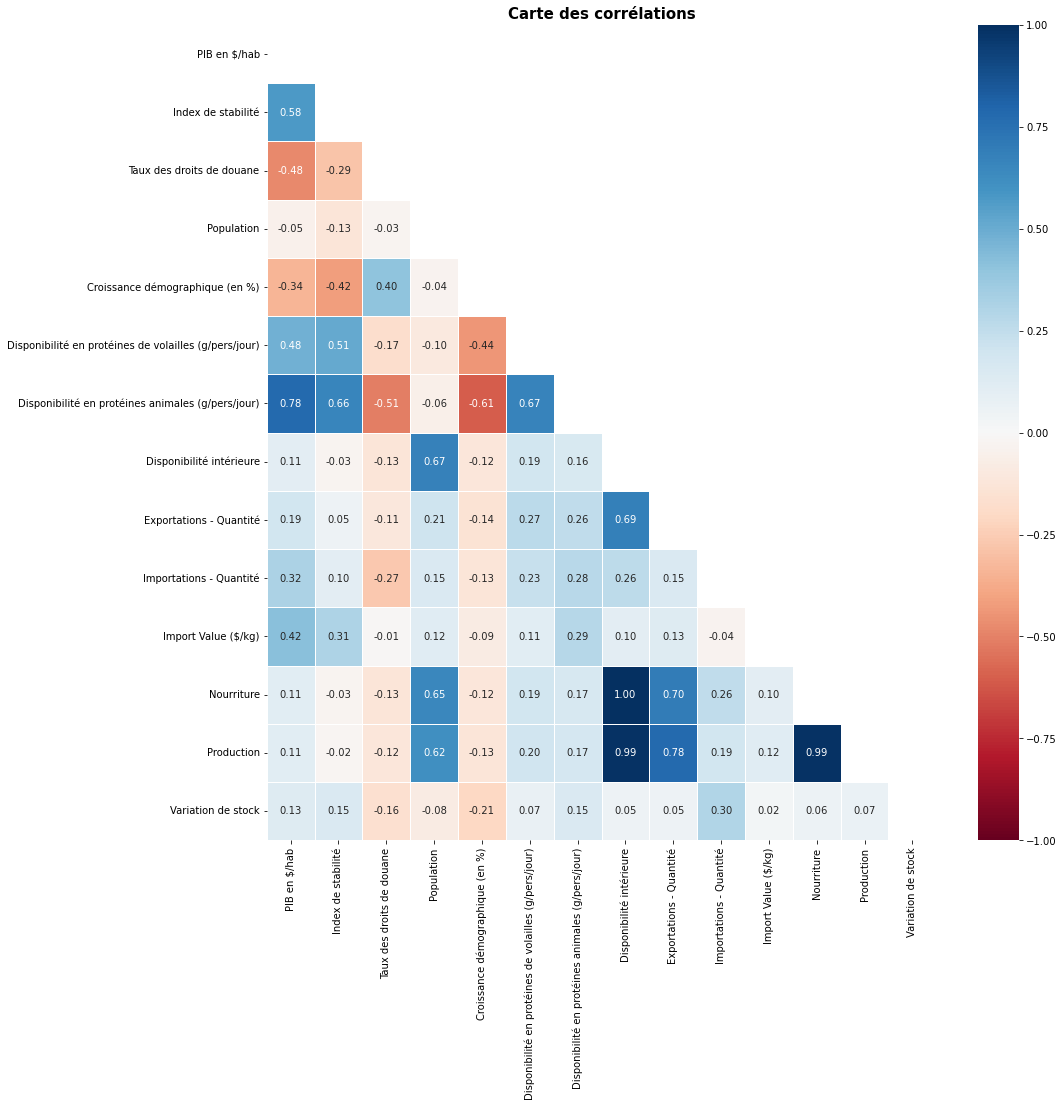

In [30]:
matrice_corr(df)

Les variables Nourriture, Production et Disponibilité intérieure sont parfaitement corrélées.<br>Nous pouvons remarquer une corrélation entre la consommation de viande et le PIB/habitant d'une part et ente la consommation de viande et la stabilité politique d'autre part.<br>La croissance démographique et les taux de droits de douanes ont une corrélation négative sur la consommation de viandes

In [31]:
df = df.drop(columns={'Disponibilité intérieure', 'Nourriture', 'Variation de stock'})

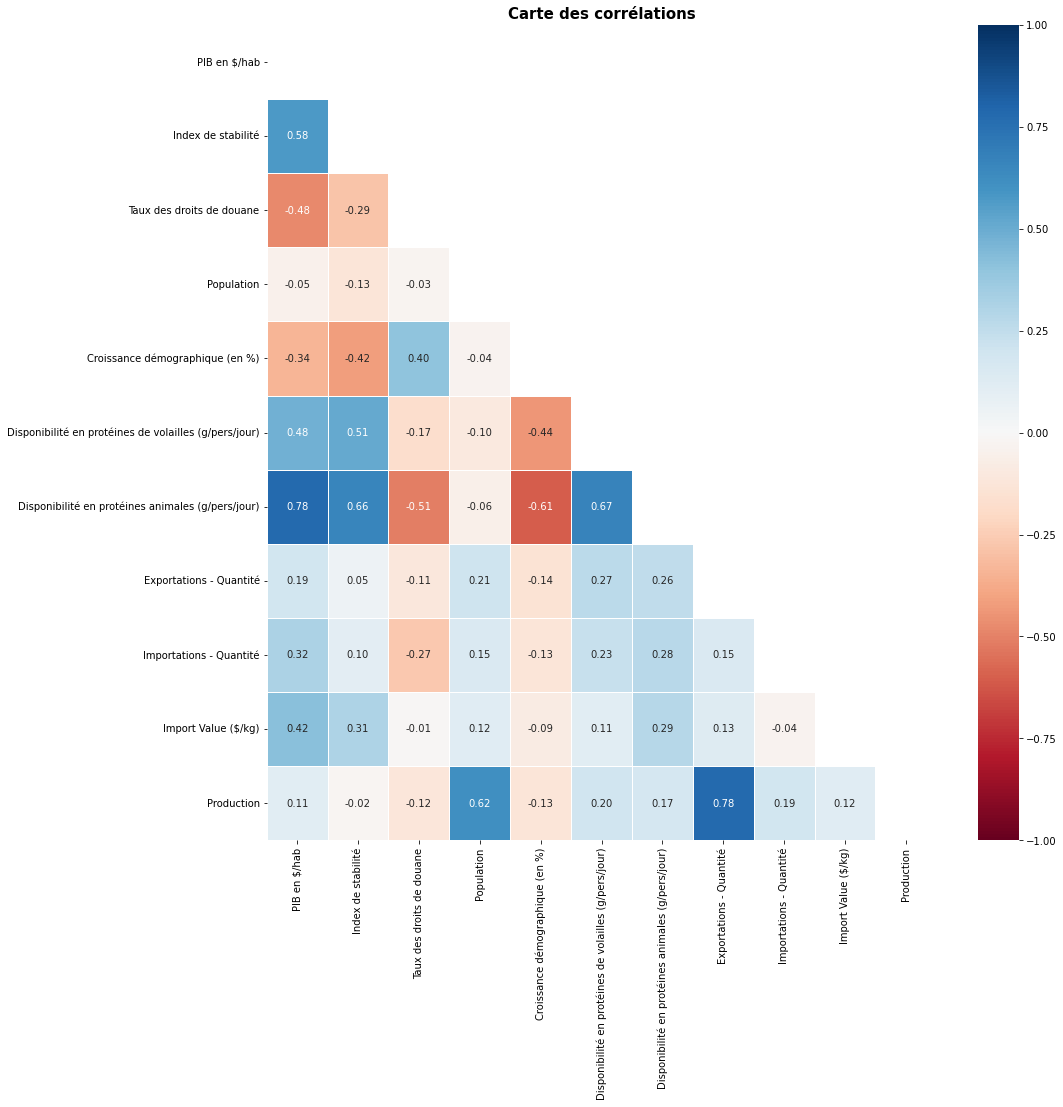

In [32]:
matrice_corr(df)